In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from joblib import dump

warnings.filterwarnings("ignore")

## Objetivo geral do trabalho:<br><br>

Criar um modelo de ML para previsão de fake news. <br><br>


## Características técnicas:
<br><br>
O treinamento dos modelos será feito nos títulos das notícias de uma base de dados em língua inglesa, cujas notícias tratam principalmente das eleições nos E.U.A em 2016.
<br><br>
Como vetorizador será utilizado o Tfidfvectorizer, que já comporta também stopwords em inglês e faz todo o processo de vetorização e estatístico de encontrar as palavras que mais se repetem, questão chave para esse trabalho.
<br><br>
Outros treinamentos serão feitos para referência e análises de modelo, assim como análise sobre as palavras mais presentes no dataset.
<br><br>
Este relatório não inclui nenhum tipo de tratamento nos dados. A base de dados utilizada já detém dados limpos.

In [2]:
#Carregando o data frame:

df = pd.read_csv('F:\GitHub\DS-Training\project_news\data_news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
#Definindo a target

target = df['label']
target
df.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

### O treinamento inicial será feito no Texto.
<br>
Como a quantidade de palavras é fundamental no processo de TF-IDF e consequentemente no modelo PAC, precisamos saber qual acurácia conseguimos alcançar treinando o modelo no texto, tendo em vista que nos títulos temos uma quantidade de palavras bem menor e os títulos serão nosso objetivo.
<br>
<br>
Essa escolha se deve aos custos computacionais, textos podem variar muito em quantidades de palavras e podem onerar servidores quando se pensa em análises em larga escala, o objetivo aqui é também ser rápido e compacto.

In [4]:
#Divisão em treino e teste:

x_train, x_test, y_train, y_test = train_test_split(df['text'], target, test_size = 0.3, random_state = 42)

In [5]:
#Iniciando o Tfidvectorizer:

tfi_df = TfidfVectorizer(stop_words = 'english', max_df = 0.7, max_features = 700) 

#max_df é a taxa de ignore de algumas palavras segundo a sua repetição
#max_features total de palavras a ser considerada no vocubulário.

tfidf_train = tfi_df.fit_transform(x_train)
tfidf_test = tfi_df.transform(x_test)
tfi_df.vocabulary_


{'months': 397,
 'donald': 180,
 'trump': 634,
 'general': 242,
 'election': 190,
 'presidential': 474,
 'look': 361,
 'forward': 233,
 'told': 629,
 'reporters': 512,
 'ohio': 430,
 'monday': 394,
 'think': 621,
 'important': 290,
 'doing': 177,
 'reason': 500,
 'long': 359,
 'agreement': 29,
 'hillary': 277,
 'clinton': 114,
 'time': 626,
 'national': 404,
 'questions': 490,
 'face': 209,
 'll': 357,
 'republican': 514,
 'nominee': 416,
 'month': 396,
 'say': 540,
 'certain': 95,
 'primary': 476,
 'debate': 157,
 'fox': 235,
 'news': 413,
 'showed': 564,
 'follow': 227,
 'threat': 624,
 'friday': 238,
 'university': 645,
 'cnn': 116,
 'lead': 335,
 'washington': 666,
 'final': 223,
 'vice': 650,
 'american': 37,
 'work': 688,
 'network': 411,
 'list': 352,
 'deal': 155,
 'past': 442,
 'gop': 252,
 'probably': 479,
 'given': 245,
 'sunday': 599,
 'events': 203,
 'used': 647,
 'fact': 211,
 'later': 331,
 'open': 433,
 've': 649,
 'got': 253,
 'end': 195,
 'sure': 603,
 'democratic': 1

Acima estão as palavras que mais se repetem nas notícias do treino, serão as palavras com mais repetições entre fakes e reais que terão mais peso nas predições. Estão colocadas de forma mais visual mais abaixo no notebook.

### Modelo PAC para texto.

In [6]:
#PassiveAgressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=50, loss = 'hinge')

#Gridsearch para encontrar os melhores parâmetros:
parametros_pac = { 'max_iter': np.arange(10,250,10), 
            'validation_fraction': np.arange(0.1,1,0.1)
            }

grid = GridSearchCV(pac,parametros_pac)
grid.fit(tfidf_train,y_train)

GridSearchCV(estimator=PassiveAggressiveClassifier(max_iter=50),
             param_grid={'max_iter': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]),
                         'validation_fraction': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [7]:
grid.best_params_

{'max_iter': 10, 'validation_fraction': 0.8}

In [8]:
#Passando os melhores paramêtros:

pac = PassiveAggressiveClassifier(max_iter=10,validation_fraction= 0.8)
pac.fit(tfidf_train,y_train)


#predict no test:

y_pred = pac.predict(tfidf_test)

score_pac = round(accuracy_score(y_test, y_pred)*100,2)
print(score_pac,'%')

89.37 %


Uma alta quantidade de palavras disponíveis resultou em uma acurácia bem alta. No Entanto, como a aleatoriedade das amostras selecionadas no processo de divisão em treino e teste é questão bem sensível para o modelo, faremos uma pequena validação cruzada para averiguar se existem grandes variações de resultados nas métricas.

In [9]:
#Validação cruzada:

scores = cross_val_score(pac,tfidf_train,y_train, cv=5)
scores

array([0.86471251, 0.86696731, 0.88726043, 0.89064262, 0.86004515])

Não existem tantas variações nas métricas, vamos visualizar uma matriz de confusão.

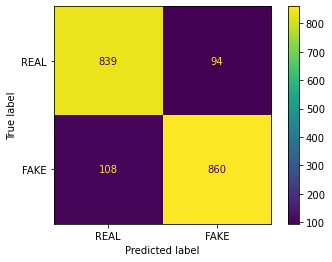

In [10]:
#Confusion matrix

labels = ['REAL','FAKE']
conf_matrix = confusion_matrix(y_test,y_pred, labels=labels)
matrix_visu = ConfusionMatrixDisplay(conf_matrix, display_labels = labels)
matrix_visu.plot()

O resultado é muito favorável a utilização do modelo, pouquíssimos falsos positivo/negativo com relação ao total de reais e fakes, e um número bem distribuido de falsos, ou seja, sem pesar muito para nenhum lado.

Testando random forest classifier como uma alternativa ao modelo pac.

In [11]:
#%%time

#Gridsearch para encontrar os melhores parâmetros:
#parametros_rand = { 'n_estimators': np.arange(100,150,10), 
                #'max_depth' : np.arange(50,100,10), 
                #'min_samples_split' : np.arange(10,50,10),
                #'min_samples_leaf' : np.arange(10,50,10)
           # }


#grid_rand = GridSearchCV(clf_f,parametros_rand)
#grid_rand.fit(tfidf_train,y_train)

In [12]:
clf_f = RandomForestClassifier(n_estimators = 150, max_depth = 200, min_samples_split=25, min_samples_leaf=10)
clf_f.fit(tfidf_train,y_train)

RandomForestClassifier(max_depth=200, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=150)

In [13]:
clf_predict = clf_f.predict(tfidf_test)
score_clf = round(accuracy_score(y_test, clf_predict)*100,2)
print(score_clf,'%')

88.9 %


Utilizando o RandomForestClassifier também encontramos um resultado considerávelmente bom. Apesar da acurácia ser um pouco menor, varia muito pouco, é um modelo utilizável.

### SVC 

<br>
Utilizando Support Vector Classification.

In [14]:
svc = SVC(random_state=0)
svc.fit(tfidf_train,y_train)

SVC(random_state=0)

In [15]:
svc_predict = svc.predict(tfidf_test)
score_svc = round(accuracy_score(y_test, svc_predict)*100,2)
print(score_svc,'%')

91.06 %


O SVC retorna uma acurácia muito boa sem nenhum tipo de ajuste de hiper parâmetros, é também um modelo utilizável.

### Criando um word cloud para visualizar quais são as palavras chave no treino

In [16]:
#juntando todas as palavras e separando em duas variáveis, uma para fakes e outra para todas as palavras.

#Fakes
only_fakes = df[df.label == "FAKE"].reset_index()

for i in np.arange(len(only_fakes)):
    fake_words = only_fakes.text[i]

#Reais
only_real = df[df.label == "REAL"].reset_index()

for i in np.arange(len(only_real)):
    real_words = only_real.text[i]

#all words
for i in np.arange(len(df)):
    all_words = df.text[i]

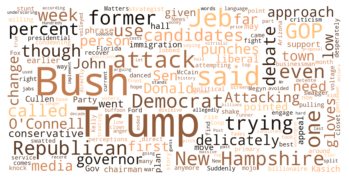

In [17]:
#Word cloud com as palavras em geral

wordcloud = WordCloud(width=1600,
                    height=800,
                    max_font_size= 200,
                     min_font_size=20,
                     background_color="white", 
                     colormap="copper").generate(all_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

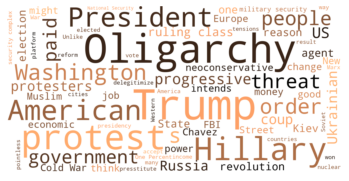

In [18]:
#Word cloud de fakes    
#Essa word cloud, serve para demonstrar bem quais palavras vão ser chave para o modelo identificar as fakes

wordcloud = WordCloud(width=1600,
                    height=800,
                    max_font_size= 200,
                     min_font_size=20,
                     background_color="white", 
                     colormap="copper").generate(fake_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

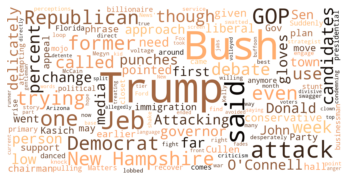

In [19]:
#Word cloud de notícias reais  

wordcloud = WordCloud(width=1600,
                    height=800,
                    max_font_size= 200,
                     min_font_size=20,
                     background_color="white", 
                     colormap="copper").generate(real_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Após visualizarmos como os modelos se comportam com o texto das notícias, passaremos para análise dos títulos. Agora poderemos comparar o quanto nós perdemos de acurácia ao trabalhar com quantidades menores de texto.

In [20]:
#Pegando os títulos

x_train, x_test, y_train, y_test = train_test_split(df['title'], target, test_size = 0.3, random_state = 42)

In [21]:
#Iniciando o Tfidvectorizer:

tfi_df = TfidfVectorizer(stop_words = 'english', max_df = 0.7) #max_df é a taxa de ignore de algumas palavras segundo a sua repetição

tfidf_train = tfi_df.fit_transform(x_train)
tfidf_test = tfi_df.transform(x_test)

In [22]:
#PassiveAgressiveClassifier

pac_t = PassiveAggressiveClassifier(max_iter=50, loss = 'hinge')

#Gridsearch para encontrar os melhores parâmetros:
parametros_pac = { 'max_iter': np.arange(10,250,10), 
            'validation_fraction': np.arange(0.1,1,0.1)
            }

grid = GridSearchCV(pac_t,parametros_pac)
grid.fit(tfidf_train,y_train)

GridSearchCV(estimator=PassiveAggressiveClassifier(max_iter=50),
             param_grid={'max_iter': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]),
                         'validation_fraction': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [23]:
grid.best_params_

{'max_iter': 10, 'validation_fraction': 0.7000000000000001}

In [24]:
#Passando os melhores paramêtros:

pac_t = PassiveAggressiveClassifier(max_iter=10,validation_fraction= 0.7)
pac_t.fit(tfidf_train,y_train)


#predict no test:

y_pred = pac_t.predict(tfidf_test)

score_pac_t = round(accuracy_score(y_test, y_pred)*100,2)
print(score_pac_t,'%')

78.49 %


É esperado que as métricas para o treino com os títulos sejam mais baixas em comparação ao modelo treinado com os textos. Isso porque a quantidade de palavras disponíveis para análise cai bastante.

In [25]:
#Validação cruzada:

""" Como a aleatoriedade das amostras podem levar a resultados diferentes nos treinos
vamos utilizar uma validação cruzada para ter maior controle do quanto as métricas do modelo variam."""

scores = cross_val_score(pac_t,tfidf_train,y_train, cv=5)
scores

array([0.78804961, 0.77677565, 0.79481398, 0.79932356, 0.7979684 ])

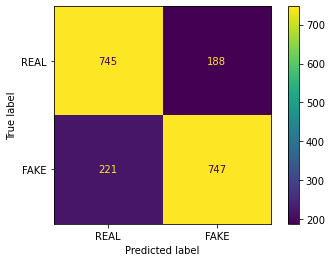

In [26]:
#Confusion matrix

labels = ['REAL','FAKE']
conf_matrix = confusion_matrix(y_test,y_pred, labels=labels)
matrix_visu = ConfusionMatrixDisplay(conf_matrix, display_labels = labels)
matrix_visu.plot()

Podemos ver que temos um número alto de matérias que são fakes e foram classificadas como reais, mas ainda sim temos uma boa acertividade do modelo, quando colocarmos em teste no mundo real poderemos averiguar melhor se essas métricas se mantém.

RandomForestClassifier:

In [27]:
clf_f_t = RandomForestClassifier(n_estimators = 150, max_depth = 200, min_samples_split=25, min_samples_leaf=10)
clf_f_t.fit(tfidf_train,y_train)

RandomForestClassifier(max_depth=200, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=150)

In [28]:
clf_predict = clf_f_t.predict(tfidf_test)
score_clf = round(accuracy_score(y_test, clf_predict)*100,2)
print(score_clf,'%')

75.43 %


In [29]:
scores = cross_val_score(clf_f_t,tfidf_train,y_train, cv=5)
scores

array([0.75084555, 0.72717024, 0.76662909, 0.77226607, 0.73476298])

SVC:

In [30]:
svc_t = SVC(random_state=0, probability = True, gamma = "scale", cache_size= 250)
svc_t.fit(tfidf_train,y_train)

SVC(cache_size=250, probability=True, random_state=0)

In [31]:
svc_predict = svc_t.predict(tfidf_test)
score_svc = round(accuracy_score(y_test, svc_predict)*100,2)
print(score_svc,'%')

82.38 %


In [32]:
scores = cross_val_score(svc_t,tfidf_train,y_train, cv=5)
scores

array([0.81848929, 0.79819617, 0.82074408, 0.8162345 , 0.80925508])

Como podemos perceber pelos últimos modelos treinados, as acurácias caem significativamente de acordo com a quantidade de texto. Mas permanecem num patamar utilizável próximos a 80%.

Vamos fazer um pequeno predict com relação a classificação dos títulos. Utilizando o modelo de maior acurácia.

In [33]:
#Título recolhido de um site de extrema direita, popular por espalhar fake news e teorias da conspiração

teste = ["EXCLUSIVE – ELECTION FRAUD ON VIDEO: Maricopa County Election Workers CAUGHT RED-HANDED Deleting “Archived” Files From Server Before Delivery To Auditors"]

teste_trans = tfi_df.transform(teste)

print(svc_t.predict(teste_trans))


['FAKE']


Com essa variedade de modelos disponíveis, mais interessante que trabalhar um refinamento muito maior para ganhos de acurácia seria utilizar todos os modelos.
<br>
Ao olharmos para o processo que ocorre nestes modelos e o objetivo deste trabalho temos que levar alguns pontos críticos em conta.
<br><br>
Notícias são conteúdos textuais e altamente mutáveis, uma notícia falsa depende de contexto, dados, exageros, omições, falácias lógicas e outras estratégias que engajam e muitas vezes são pensadas para um público específico já receptivo a certas opiniões pré-moldadas.
<br>
Por essa perspectiva, ao colocarmos nossos modelos para trabalhar, acurácias de 80% são muito mais que o esperado, isso porque, como já explicitado, existem muitos fatores que interferem no sentido geral da notícia. Se nossos modelos conseguem perceber minúcias tais, é em si, uma vitória.
<br>
Acredito que fazer uso das predições de todos os 3 modelos estudados aqui é de maior valor. A utilização de um único, mesmo que com acurácias bem altas, aumenta o risco de cairmos nas armadilhas da variação de cenários que se encontram as notícias falsas. 
<br>
Farei uso dos 3 modelos aqui treinados para uma pequena interface para usuários poderem testar títulos de notícias e receberem um feedback se devem se atentar ao conteúdo das matérias jornalísticas.
<br>

Como podemos perceber alguma reprodutibilidade no modelo, vamos então treinar o modelo com todos os dados que temos para aplicá-lo ao mundo real em sequência:

In [34]:
#vetorizando toda coluna titles:
tfidf_titles = tfi_df.fit_transform(df["title"])

#Treinando os 3 modelos finais separados dos outros apenas para melhora de visualização.

#pac:

pac_t_final = PassiveAggressiveClassifier(max_iter=10,validation_fraction= 0.7)
pac_t_final.fit(tfidf_titles,target)


#rfc:
clf_f_t_final = RandomForestClassifier(n_estimators = 150, max_depth = 200, min_samples_split=25, min_samples_leaf=10)
clf_f_t_final.fit(tfidf_titles,target)

svc_t_final = SVC(random_state=0, probability = True, gamma = "scale", cache_size= 250)
svc_t_final.fit(tfidf_titles,target)

SVC(cache_size=250, probability=True, random_state=0)

In [35]:
dump(pac_t_final,"API\model\model_pac_titles.joblib")

dump(clf_f_t_final,"API\model\model_clf_titles.joblib")

dump(svc_t_final,"API\model\model_svc_titles.joblib")

dump(tfi_df,"API\model\dfi_vectorizer.joblib")

['site\\model\\dfi_vectorizer.joblib']